## Setup ##

In [14]:
"""Display examples of each type of augmentation and how to use Augmentor"""
import sys; sys.path.append('/usr/people/kluther/seungmount/research/kluther/augment3d/augment/')
import tifffile
import os
import matplotlib.pyplot as plt
import numpy as np

import augment
import blur
import circle
import elastic_warp
import flip
import misalign
import missing_section
import rescale
import rotate90

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
data_dir = '/usr/people/kluther/seungmount/research/kluther/data/ISBI_SEGMENTS/train/'
volume = np.expand_dims(tifffile.imread(os.path.join(data_dir, 'volume.tif')), -1).astype(np.int32)
labels = np.expand_dims(tifffile.imread(os.path.join(data_dir, 'labels.tif')), -1).astype(np.float32)

print('volume type: {}'.format(volume.dtype))
print('labels type: {}'.format(labels.dtype))
print('volume shape: {}'.format(volume.shape))
print('labels shape: {}'.format(labels.shape))

volume type: int32
labels type: float32
volume shape: (20, 512, 512, 1)
labels shape: (20, 512, 512, 1)


## Augmentor ##

In [53]:
""" General use of augmentation:
>>> augmentor = Augmentor(params)
>>> img, [label1, label2, ...] = augmentor.augment(img, [label1, label2, ...])
"""
params = { 
      'blur': True,
         'blur_prob': 0.01,
         'blur_sigma': 3,
      'circle': True,
         'circle_prob': 0.01,
         'circle_radius': 10,
      'elastic_warp': True,
         'elastic_grid_size': 4,
         'elastic_sigma': 5,
         'elastic_d': 3,
      'flip': True,
      'misalign': True,
         'misalign_prob': 0.01,
         'misalign_delta': 10,
         'misalign_type': 'slip',
         'misalign_label_shift': True,
      'missing_section': True,
         'missing_section_prob': 0.01,
      'rescale': True,
         'rescale_min': 0.8,
         'rescale_max': 1.2,
      'rotate90': True
}
augmentor = augment.Augmentor(params)
img_batch = [volume[5*i:5*(i+1)] for i in range(2)]
label_batch = [labels[5*i:5*(i+1)] for i in range(2)]
augmented_img_batch = []
augmented_label_batch = []

for img, label in zip(img_batch, label_batch):
    augmented_img, [augmented_label] = augmentor.augment(img, [label])
    augmented_img_batch.append(augmented_img)
    augmented_label_batch.append(augmented_label)

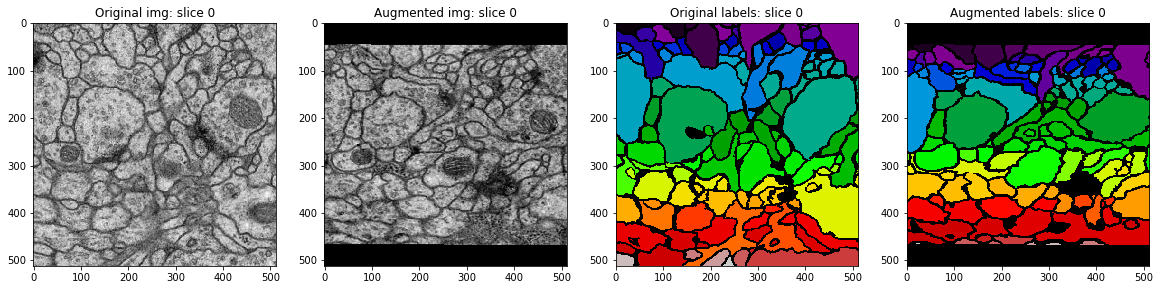

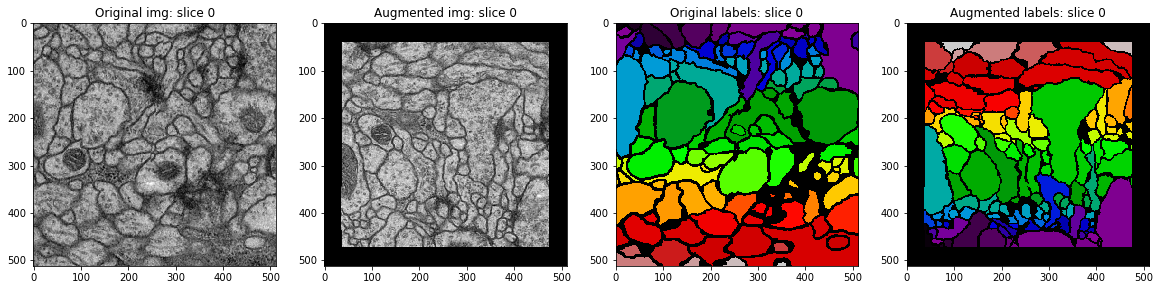

In [54]:
imgs = zip(img_batch, augmented_img_batch, label_batch, augmented_label_batch)
for img, augmented_img, label, augmented_label in imgs:
    plt.figure(figsize=(20,5))
    
    plt.subplot(141)
    plt.title('Original img: slice 0')
    plt.imshow(np.squeeze(img[0]), cmap='gray')
    
    plt.subplot(142)
    plt.title('Augmented img: slice 0')
    plt.imshow(np.squeeze(augmented_img[0]), cmap='gray')
    
    
    plt.subplot(143)
    plt.title('Original labels: slice 0')
    plt.imshow(np.squeeze(label[0]), cmap='nipy_spectral')
    
    
    plt.subplot(144)
    plt.title('Augmented labels: slice 0')
    plt.imshow(np.squeeze(augmented_label[0]), cmap='nipy_spectral')
    plt.show()

## Blur ##

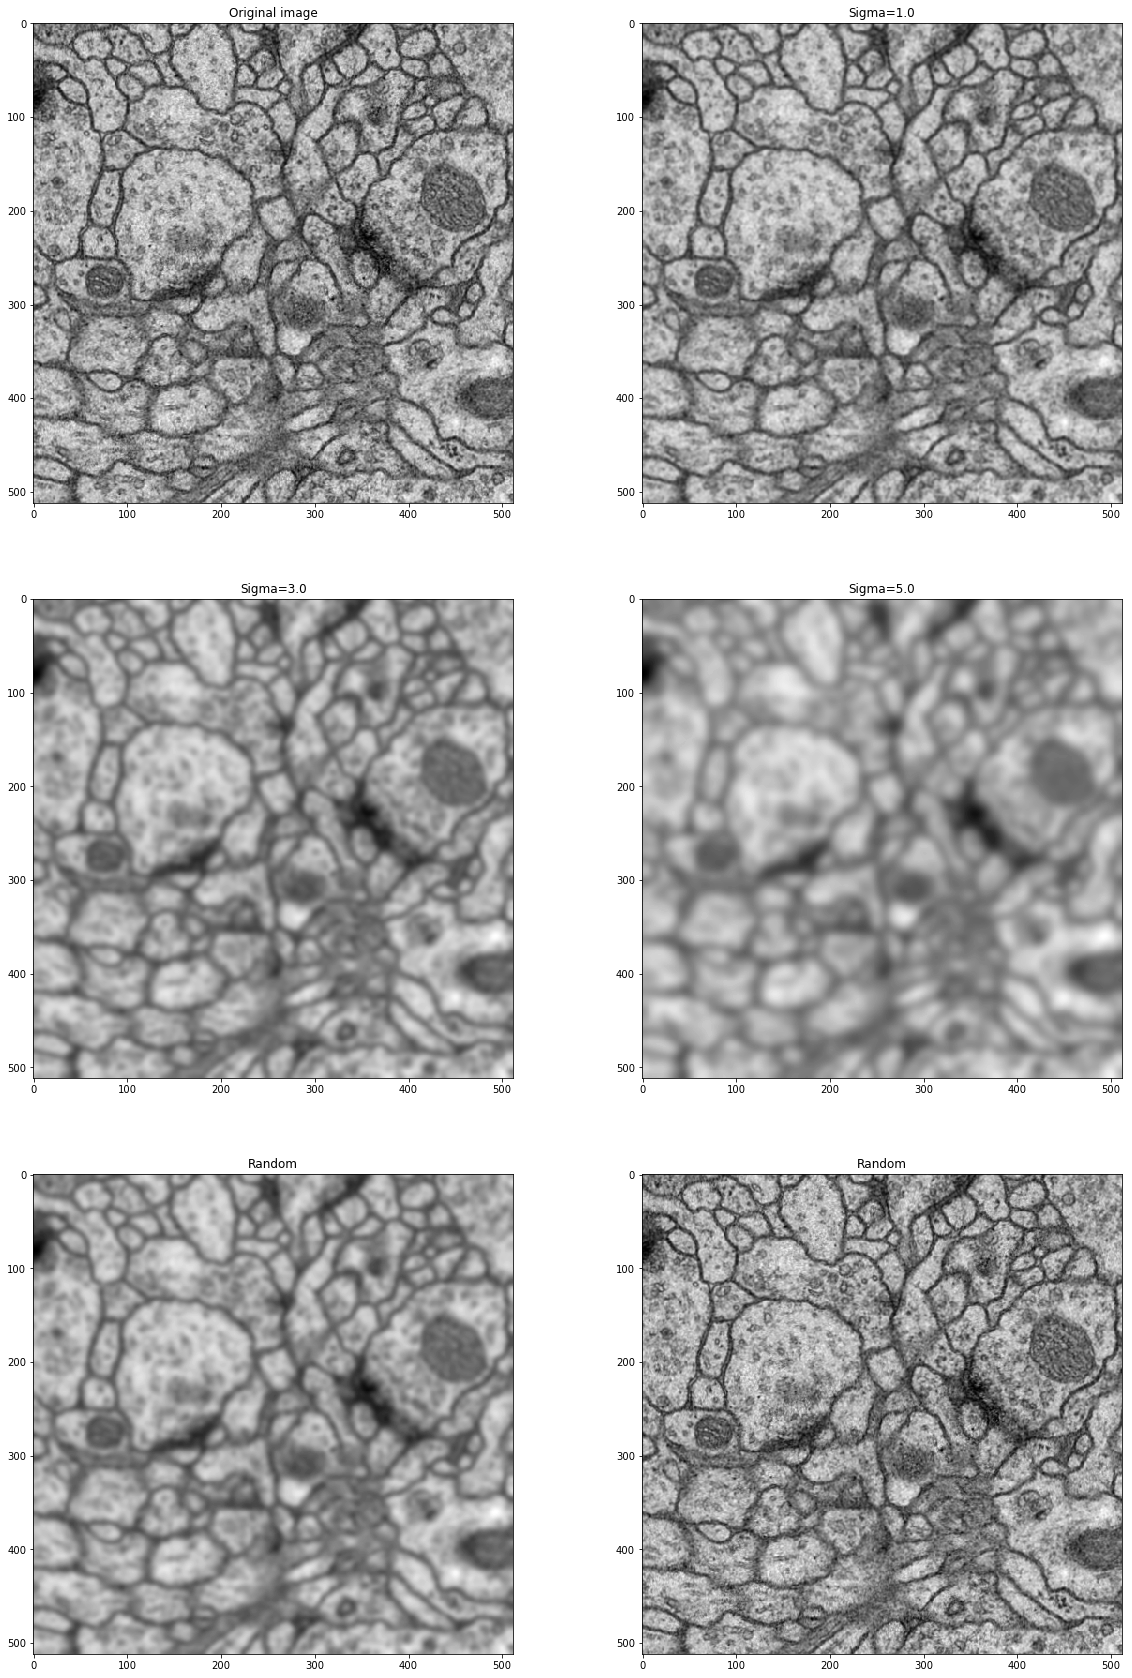

In [33]:
img = volume[0:2]
sigmas = [1.0,3.0,5.0]

# Fixed
augmented_imgs_fixed = []
for sigma in sigmas:
    augmented_imgs_fixed.append(blur.gaussian_filter(img[0], sigma))
    
# Random
augmented_imgs_rnd = []
sigma = 5.0
p = 0.5
for i in range(2):
    augmented_imgs_rnd.append(blur.blur_augment(img, sigma, p))
    
# Plot
plt.figure(figsize=(20,30))
plt.subplot(321)
plt.title('Original image')
plt.imshow(np.squeeze(img[0]), cmap='gray')

plt.subplot(322)
plt.title('Sigma={}'.format(sigmas[0]))
plt.imshow(np.squeeze(augmented_imgs_fixed[0]), cmap='gray')

plt.subplot(323)
plt.title('Sigma={}'.format(sigmas[1]))
plt.imshow(np.squeeze(augmented_imgs_fixed[1]), cmap='gray')

plt.subplot(324)
plt.title('Sigma={}'.format(sigmas[2]))
plt.imshow(np.squeeze(augmented_imgs_fixed[2]), cmap='gray')

plt.subplot(325)
plt.title('Random')
plt.imshow(np.squeeze(augmented_imgs_rnd[0][0]), cmap='gray')

plt.subplot(326)
plt.title('Random')
plt.imshow(np.squeeze(augmented_imgs_rnd[1][0]), cmap='gray')

plt.show()


## Circle ##

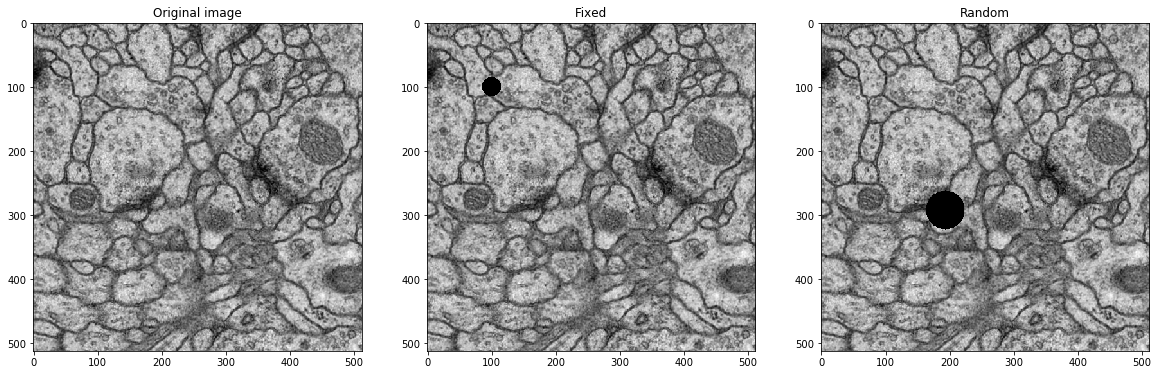

In [58]:
img = volume[0:2]

# Fixed
r = 15
zc, yc, xc = (0, 100, 100)
yy, xx = circle.circle(yc, xc, r, shape=(512,512))
img_fixed = np.copy(img)
img_fixed[zc, yy, xx, :] = 0.0

# Random
p = 0.5
max_r = 100
img_random = circle.circle_augment(img, p, max_r)

# Plot
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Original image')
plt.imshow(np.squeeze(img[0]), cmap='gray')

plt.subplot(132)
plt.title('Fixed')
plt.imshow(np.squeeze(img_fixed[0]), cmap='gray')

plt.subplot(133)
plt.title('Random')
plt.imshow(np.squeeze(img_random[0]), cmap='gray')

plt.show()

## Elastic Warp ##

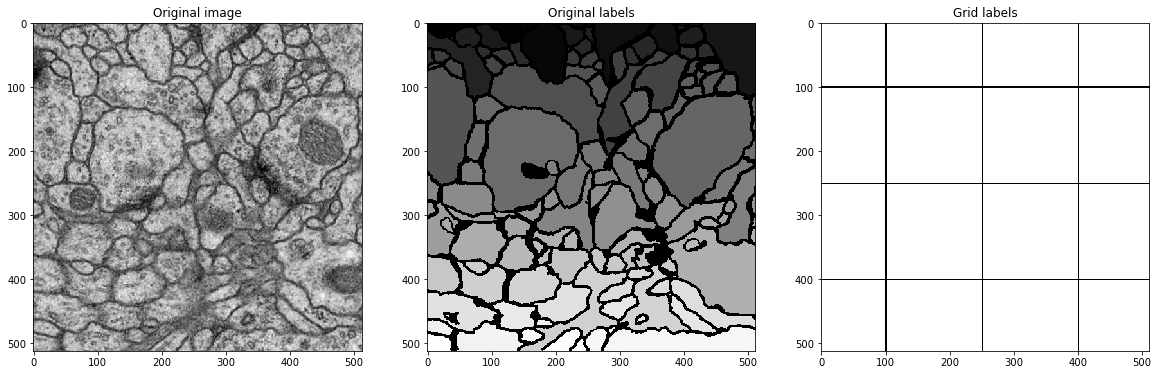

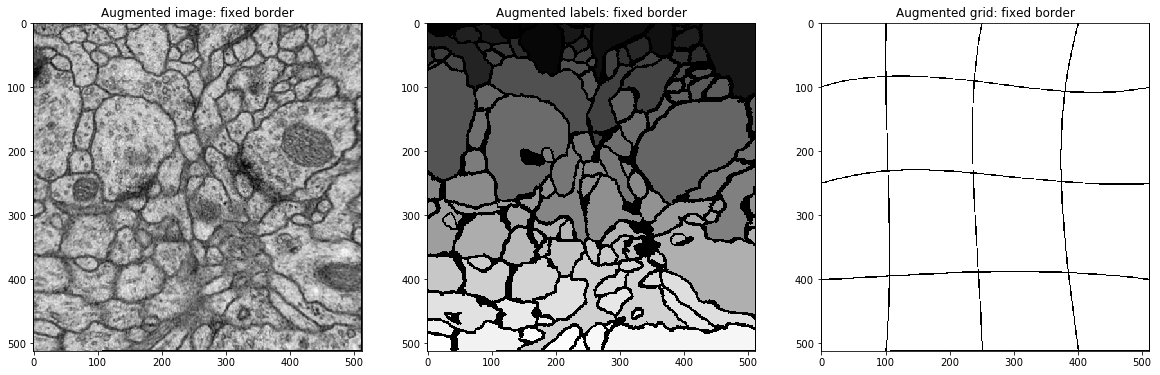

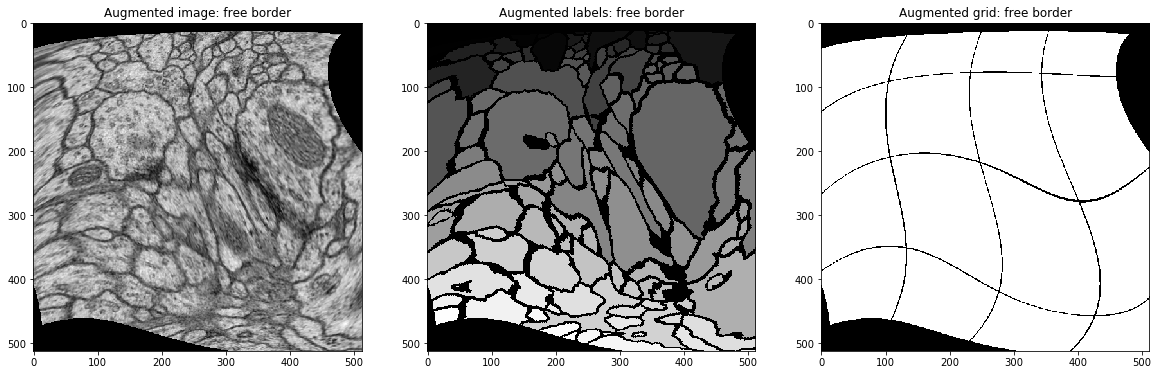

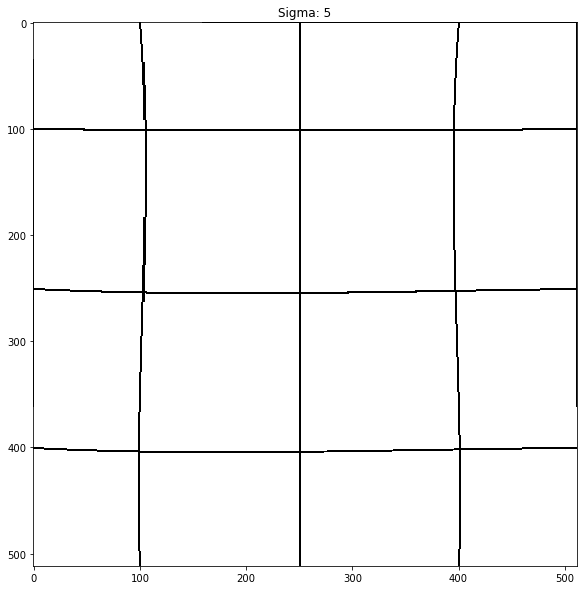

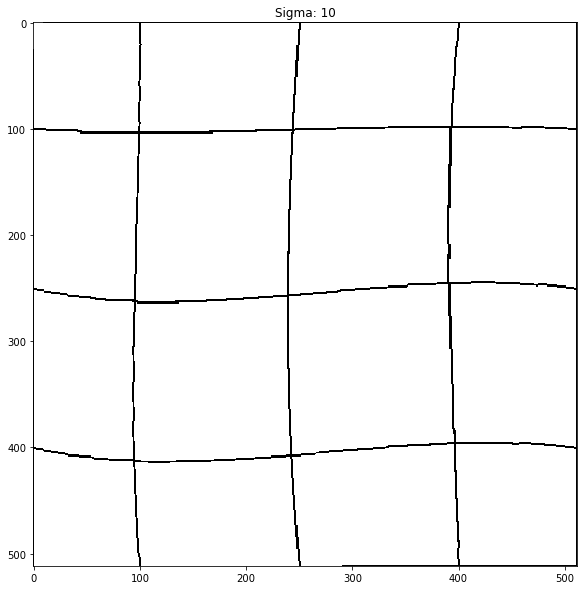

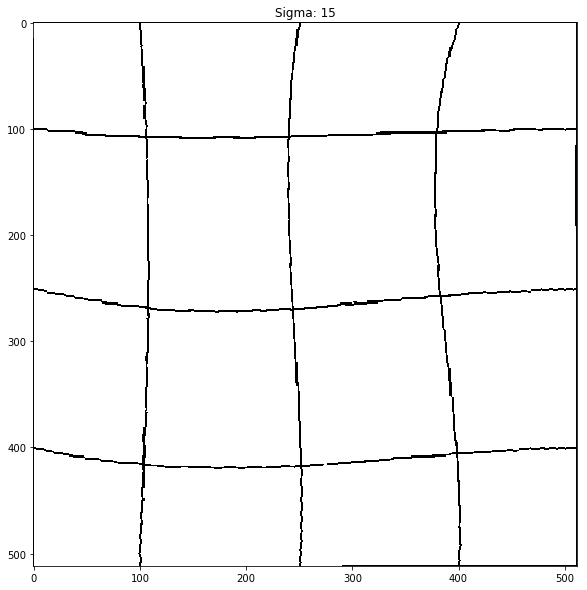

In [110]:
# Original data
img = np.copy(volume[0:2])
labs = np.copy(labels[0:2])
grid = np.ones_like(labs)
grid[:,100:102,:] = grid[:,:,100:102] = grid[:,250:252,:] = grid[:,:,250:252] = grid[:,400:402,:] = grid[:,:,400:402] = 0

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Original image')
plt.imshow(np.squeeze(img[0]), cmap='gray')

plt.subplot(132)
plt.title('Original labels')
plt.imshow(np.squeeze(labs[0]), cmap='gray')

plt.subplot(133)
plt.title('Grid labels')
plt.imshow(np.squeeze(grid[0]), cmap='gray')
plt.show()

# Random: borders clamped
n = 4
max_sigma = 50
d = 3
clamp_borders = True
img_rnd, [labs_rnd, grid_rnd] = elastic_warp.elastic_warp_augment(img, [labs, grid], n, max_sigma, d, clamp_borders)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Augmented image: fixed border')
plt.imshow(np.squeeze(img_rnd[0]), cmap='gray')

plt.subplot(132)
plt.title('Augmented labels: fixed border')
plt.imshow(np.squeeze(labs_rnd[0]), cmap='gray')

plt.subplot(133)
plt.title('Augmented grid: fixed border')
plt.imshow(np.squeeze(grid_rnd[0]), cmap='gray')
plt.show()

# Random: borders free
clamp_borders = False
img_rnd, [labs_rnd, grid_rnd] = elastic_warp.elastic_warp_augment(img, [labs, grid], n, max_sigma, d, clamp_borders)
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Augmented image: free border')
plt.imshow(np.squeeze(img_rnd[0]), cmap='gray')

plt.subplot(132)
plt.title('Augmented labels: free border')
plt.imshow(np.squeeze(labs_rnd[0]), cmap='gray')

plt.subplot(133)
plt.title('Augmented grid: free border')
plt.imshow(np.squeeze(grid_rnd[0]), cmap='gray')
plt.show()

# Fixed: various sigma 
n = 4
d = 3
clamp_borders = True

sigma = 5
img_fx, [grid_fx] = elastic_warp.elastic_warp3d(img, [grid], n, sigma, clamp_borders)
plt.figure(figsize=(20,10))
plt.title('Sigma: 5')
plt.imshow(np.squeeze(grid_fx[0]), cmap='gray')
plt.show()

sigma = 10
img_fx, [grid_fx] = elastic_warp.elastic_warp3d(img, [grid], n, sigma, clamp_borders)
plt.figure(figsize=(20,10))
plt.title('Sigma: 10')
plt.imshow(np.squeeze(grid_fx[0]), cmap='gray')
plt.show()

sigma = 15
img_fx, [grid_fx] = elastic_warp.elastic_warp3d(img, [grid], n, sigma, clamp_borders)
plt.figure(figsize=(20,10))
plt.title('Sigma: 15')
plt.imshow(np.squeeze(grid_fx[0]), cmap='gray')
plt.show()


## Flip ## 

## Misalign ##

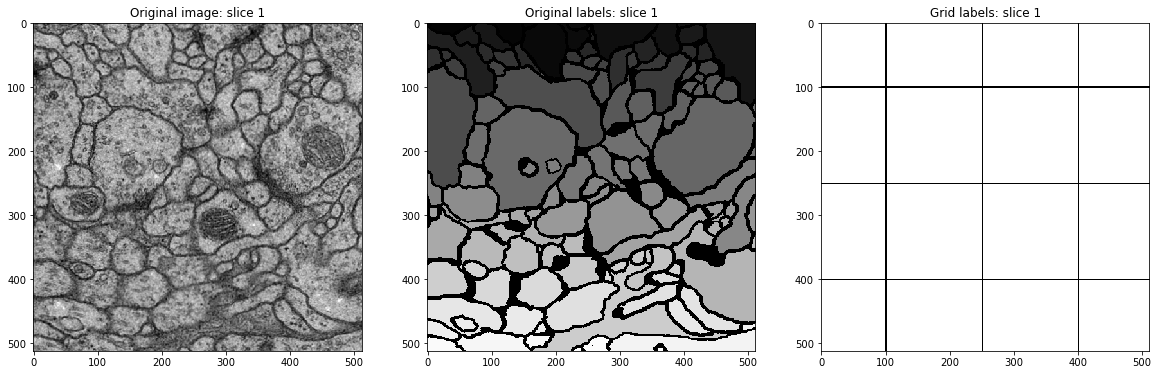

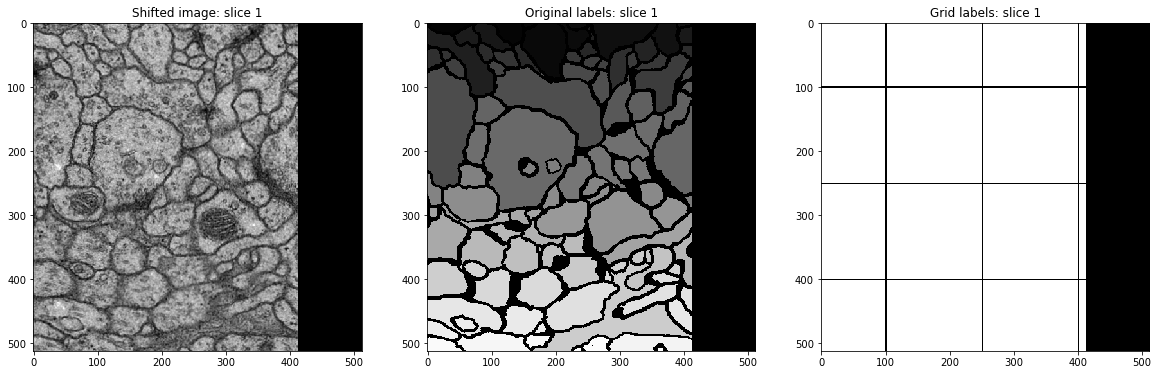

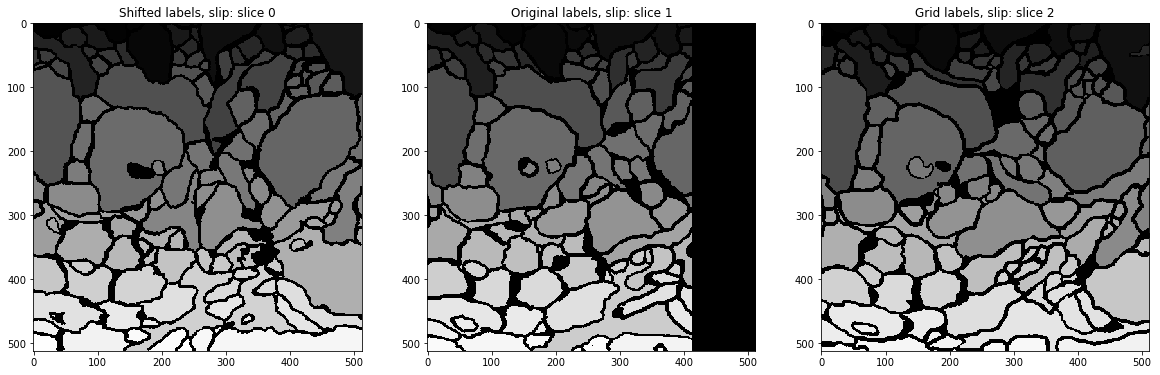

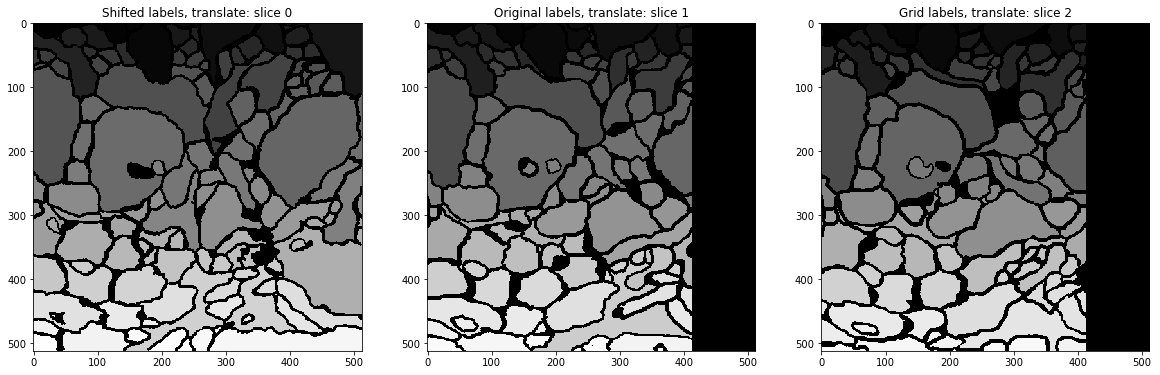

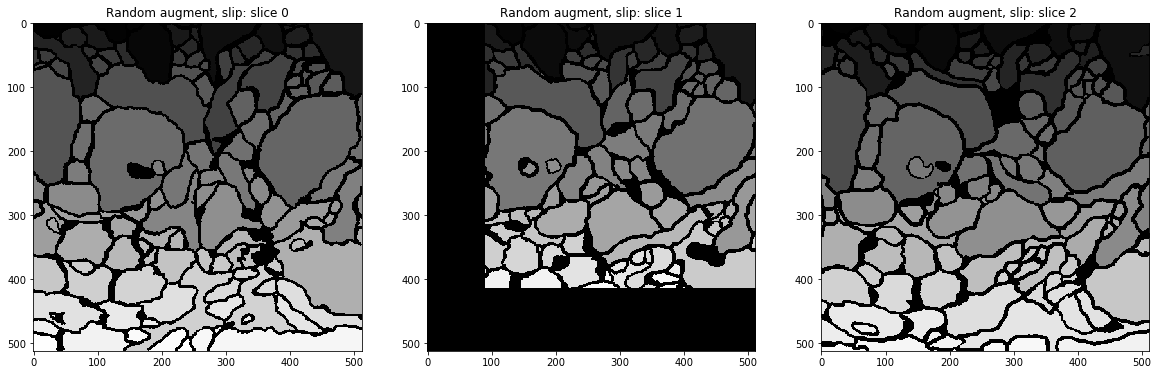

In [143]:
# Original data
img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])
grid = np.ones_like(labs)
grid[:,100:102,:] = grid[:,:,100:102] = grid[:,250:252,:] = grid[:,:,250:252] = grid[:,400:402,:] = grid[:,:,400:402] = 0

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Original image: slice 1')
plt.imshow(np.squeeze(img[1]), cmap='gray')

plt.subplot(132)
plt.title('Original labels: slice 1')
plt.imshow(np.squeeze(labs[1]), cmap='gray')

plt.subplot(133)
plt.title('Grid labels: slice 1')
plt.imshow(np.squeeze(grid[1]), cmap='gray')
plt.show()

# Fixed shift: slip
z = 1
dx = -100
dy = 0
shift_labels = True

img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])
grid = np.ones_like(labs)
grid[:,100:102,:] = grid[:,:,100:102] = grid[:,250:252,:] = grid[:,:,250:252] = grid[:,400:402,:] = grid[:,:,400:402] = 0
img_fx, [labs_fx, grid_fx] = misalign.apply_slip(img, [labs, grid], z, dx, dy, shift_labels)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Shifted image: slice 1')
plt.imshow(np.squeeze(img_fx[1]), cmap='gray')

plt.subplot(132)
plt.title('Original labels: slice 1')
plt.imshow(np.squeeze(labs_fx[1]), cmap='gray')

plt.subplot(133)
plt.title('Grid labels: slice 1')
plt.imshow(np.squeeze(grid_fx[1]), cmap='gray')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Shifted labels, slip: slice 0')
plt.imshow(np.squeeze(labs_fx[0]), cmap='gray')

plt.subplot(132)
plt.title('Original labels, slip: slice 1')
plt.imshow(np.squeeze(labs_fx[1]), cmap='gray')

plt.subplot(133)
plt.title('Grid labels, slip: slice 2')
plt.imshow(np.squeeze(labs_fx[2]), cmap='gray')
plt.show()

# Fixed shift: translate
img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])
grid = np.ones_like(labs)
grid[:,100:102,:] = grid[:,:,100:102] = grid[:,250:252,:] = grid[:,:,250:252] = grid[:,400:402,:] = grid[:,:,400:402] = 0
img_fx, [labs_fx, grid_fx] = misalign.apply_translation(img, [labs, grid], z, dx, dy)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Shifted labels, translate: slice 0')
plt.imshow(np.squeeze(labs_fx[0]), cmap='gray')

plt.subplot(132)
plt.title('Original labels, translate: slice 1')
plt.imshow(np.squeeze(labs_fx[1]), cmap='gray')

plt.subplot(133)
plt.title('Grid labels, translate: slice 2')
plt.imshow(np.squeeze(labs_fx[2]), cmap='gray')
plt.show()

# Random Augmentation
img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])
grid = np.ones_like(labs)
grid[:,100:102,:] = grid[:,:,100:102] = grid[:,250:252,:] = grid[:,:,250:252] = grid[:,400:402,:] = grid[:,:,400:402] = 0

p = 1.0
delta = 100
type = 'slip'
shift_labels = True
img_fx, [labs_fx, grid_fx] = misalign.misalign_augment(img, [labs, grid], p, delta, type, shift_labels)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Random augment, slip: slice 0')
plt.imshow(np.squeeze(labs_fx[0]), cmap='gray')

plt.subplot(132)
plt.title('Random augment, slip: slice 1')
plt.imshow(np.squeeze(labs_fx[1]), cmap='gray')

plt.subplot(133)
plt.title('Random augment, slip: slice 2')
plt.imshow(np.squeeze(labs_fx[2]), cmap='gray')
plt.show()

## Missing Section ##

## Rescale ##

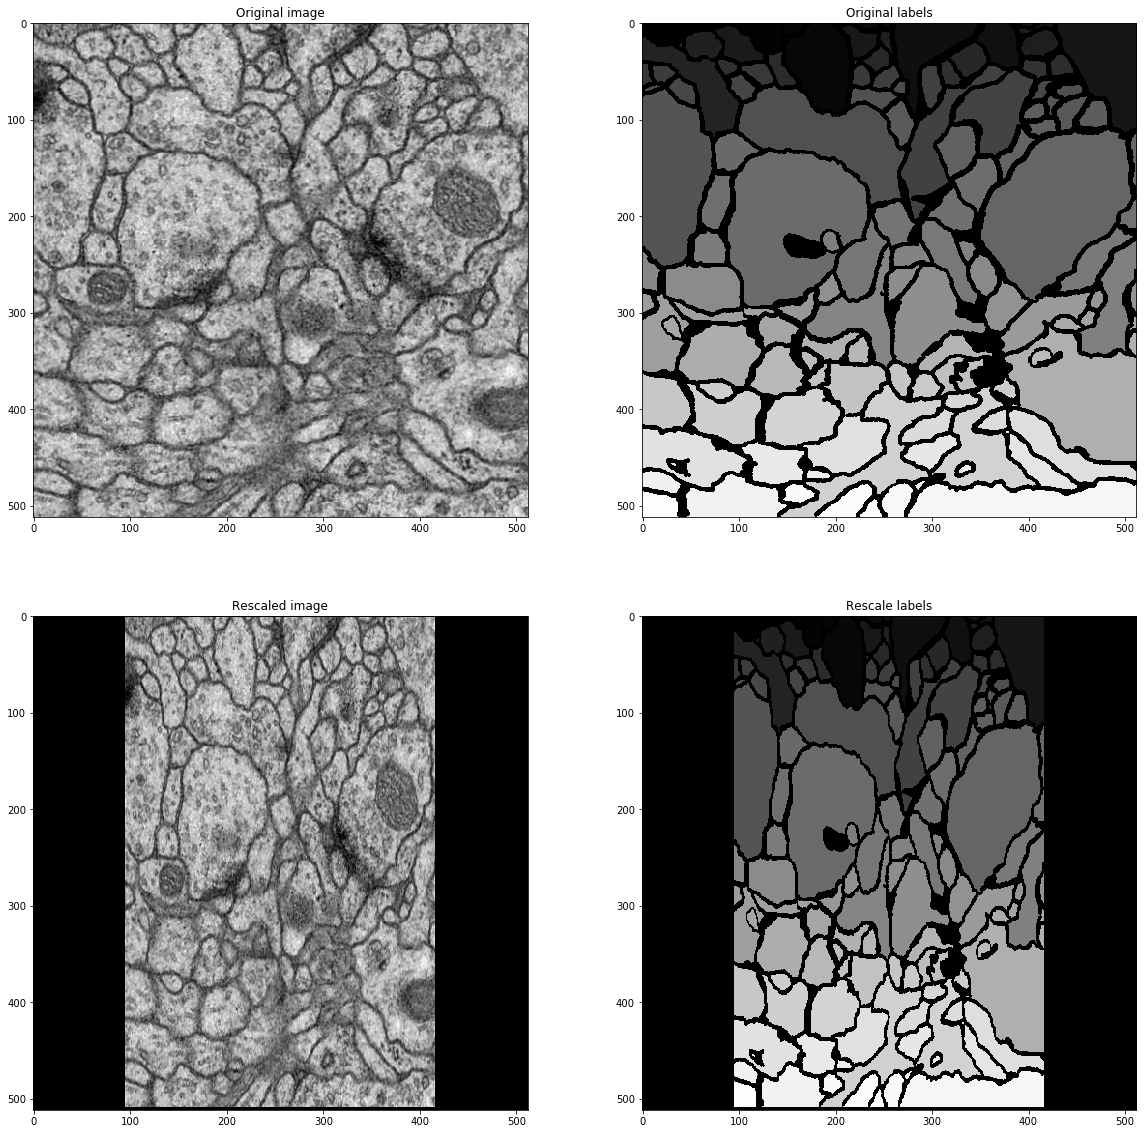

In [50]:
img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])

min_f = 0.5
max_f = 1.5
rescale_img, [rescale_labs] = rescale.rescale_augment(img, [labs], min_f, max_f)
img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Original image')
plt.imshow(np.squeeze(img[0]), cmap='gray')

plt.subplot(222)
plt.title('Original labels')
plt.imshow(np.squeeze(labs[0]), cmap='gray')

plt.subplot(223)
plt.title('Rescaled image')
plt.imshow(np.squeeze(rescale_img[0]), cmap='gray')

plt.subplot(224)
plt.title('Rescale labels')
plt.imshow(np.squeeze(rescale_labs[0]), cmap='gray')
plt.show()

## Rotate90 ##